# Social Network Analysis

## Implementation

Unfortunately visualizations aren't clear even if they are related to a subgraph. I tried to change the font size, not display the labels or increase the dimension of the plot but it didn't help. In addition to this, running the notebook took a lot of time so I couldn't try that many different options.

In [1]:
import csv
import typing
import networkx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.decomposition import PCA

In [10]:
def load_data(fn):
    data = []

    with open(fn) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            data.append(row)

    return data


def parse_row(row):
    
    roles = row[4].split(':', 1)
    role_prefix = roles[0]
    try:
        role_content = roles[1]
    except IndexError:
        role_content = ""
    
    if not row[2]:
        actor_name = ""
    else:
        actor_name = row[2]
        
    return {
            "film_id": row[0], 
            "film_title": row[1],
            "actor_name": row[2], 
            "role_type": row[3], 
            "role_prefix": role_prefix, 
            "role_content": role_content
            }
       

def create_graph(records):
    map_fa = {}  # {movie: [actor1, actor2, ...]}
    
    g = networkx.Graph()
    for record in records:  
        title = record["film_title"]
        if title not in map_fa:
            map_fa[title] = []
        map_fa[record["film_title"]].append(record["actor_name"])
    
    for record in records:
        title = record["film_title"]
        #if len(map_fa[title]) < 5: # comment this line and shift left the next one for full graph
        g.add_node(record["actor_name"]) 

    for film, actors in map_fa.items():   
        #if len(actors) < 5:  # comment this line and shift left the next one for full graph
            for a1 in actors:
                for a2 in actors:
                    if a1 != a2:
                        g.add_edge(a1, a2)

    return g


def communities(graph):
    communities = {}
    for cid, community in enumerate(networkx.algorithms.community.k_clique_communities(graph, 3)):
        for node in community:
            communities[node] = cid + 1

    # Group by communities
    communities_grouped = {}
    for key, val in communities.items():
        if val not in communities_grouped:
            communities_grouped[val] = []
        communities_grouped[val].append(key)

    communities_sorted = sorted(communities_grouped.items(), key=lambda element: len(element[1]), reverse=True)

    print("COMMUNITIES")
    for community in communities_sorted[:10]:
        if(len(community[1]) > 15):
            actors = community[1][:15]
            print("ID {}, {} actors: {}".format(community[0], len(community[1]), ", ".join(actors) + ", ..."))
        else:
            print("ID {}, {} actors: {}".format(community[0], len(community[1]), ", ".join(community[1])))
    
    # Add to graph
    for actor, cid in communities.items():
        graph.nodes[actor]['cid'] = cid
    
    # Comment to disable
    visualize_communities(graph, communities_sorted)
    
    return


def visualize_communities(graph, communities_sorted):
    pos = networkx.circular_layout(graph)
    networkx.draw_networkx(graph, pos, font_size=3,
                  labels={v: str(v) for v in graph},
                  cmap=plt.get_cmap("rainbow"),
                  node_color=[communities_sorted[v] if v in communities_sorted else 0 for v in graph])
    plt.savefig("communities.png")
    
    return

    
def centralities(graph: networkx.Graph):
    centralities = [
        networkx.degree_centrality,
        networkx.closeness_centrality,
        networkx.betweenness_centrality,
        networkx.eigenvector_centrality
    ]

    print("CENTRALITIES")
    pos = networkx.circular_layout(graph)
    region = 220
    for centrality in centralities:
        centrality_res = centrality(graph)
        region += 1
        plt.subplot(region)
        plt.title(centrality.__name__)
        networkx.draw_networkx(graph, pos, font_size=3, labels={v: str(v) for v in graph},
                      cmap=plt.get_cmap("bwr"), node_color=[centrality_res[k] for k in centrality_res])
        # Add as node attribute
        for actor, centrality_val in centrality_res.items():
            graph.nodes[actor][centrality.__name__] = centrality_val

        centrality_res_sorted = sorted(centrality_res.items(), key=lambda element: element[1], reverse=True)
        print("-"*80)
        print(centrality.__name__ + " - top 5: \n")
        print("{}".format("\n".join(["{} --> {:.5}".format(elm[0], elm[1]) for elm in centrality_res_sorted[:5]])))

    plt.savefig("centralities.png")
    #visualize_centralities(graph, centralities)
    
    return


def visualize_centralities(graph, centralities):
    
    pos = networkx.circular_layout(graph)
    region = 220
    for centrality in centralities:
        region += 1
        plt.subplot(region)
        plt.title(centrality.__name__)
        networkx.draw_networkx(graph, pos, font_size=3, labels={v: str(v) for v in graph},
                      cmap=plt.get_cmap("bwr"), node_color=[centrality(graph)[k] for k in centrality(graph)])
        print("step done")
    plt.savefig("centralities.png")
    
    return


def kevbacon(graph, person='James Stewart'):
    lengths = networkx.single_source_shortest_path_length(graph, person)

    for actor in graph.nodes():
        graph.nodes[actor]['KevBaconLength'] = -1

    # Compute average from reachable nodes
    length_sum = 0
    length_count = 0
    for actor, length in lengths.items():
        graph.nodes[actor]['KevBaconLength'] = length
        length_sum += length
        length_count += 1
    bacon_average = length_sum / length_count

    lengths_sorted = sorted(lengths.items(), key=lambda element: element[1], reverse=True)

    print("KEVIN BACON")
    print("From person: {}".format(person))
    print("Average: {}".format(bacon_average))
    print("Lowest 10: {}".format(
        ", ".join(["{} ({})".format(actorlen[0], actorlen[1]) for actorlen in lengths_sorted[-10:]])))
    print("Highest 10:  {}".format(
        ", ".join(["{} ({})".format(actorlen[0], actorlen[1]) for actorlen in lengths_sorted[:10]])))
    
    return



In [11]:
data = load_data('casts.csv')
records = []
for row in data:
    records.append(parse_row(row))

graph = create_graph(records)

print("GENERAL STATISTICS")
nodes = graph.number_of_nodes()
edges = graph.number_of_edges()
density = edges / (nodes * (nodes - 1) / 2)
components = networkx.number_connected_components(graph)
print("Number of nodes: {} \nNumber of edges: {} \nDensity: {:.6} \nNumber of components: {}"
      .format(nodes, edges, density, components))

GENERAL STATISTICS
Number of nodes: 16615 
Number of edges: 155660 
Density: 0.0011278 
Number of components: 637


CENTRALITIES
--------------------------------------------------------------------------------
degree_centrality - top 5: 

s a --> 0.19923
Humphrey Bogart --> 0.025942
James Stewart --> 0.022511
Gary Cooper --> 0.02227
John Gielgud --> 0.02227
--------------------------------------------------------------------------------
closeness_centrality - top 5: 

s a --> 0.47356
Charlton Heston --> 0.36845
John Gielgud --> 0.367
John Carradine --> 0.36667
Burt Lancaster --> 0.3665
--------------------------------------------------------------------------------
betweenness_centrality - top 5: 

s a --> 0.34454
Humphrey Bogart --> 0.0083201
Vincent Price --> 0.0077839
John Carradine --> 0.0070353
Jack Nicholson --> 0.0066696
--------------------------------------------------------------------------------
eigenvector_centrality - top 5: 

s a --> 0.32584
C.Aubrey Smith --> 0.087044
John Carradine --> 0.085586
James Stewart --> 0.083652
John Gielgud --> 0.081382


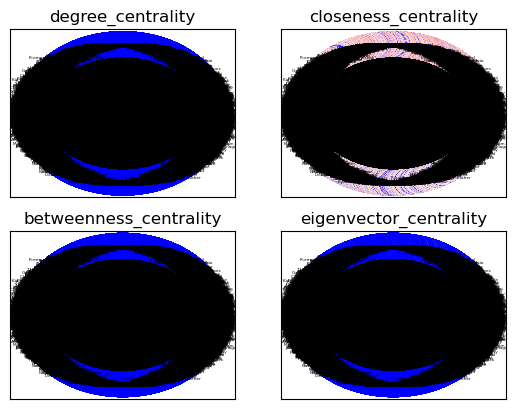

In [12]:
centralities(graph)
#communities(graph)
#kevbacon(graph)

#networkx.write_gexf(graph, 'whole_graph.gexf')
#networkx.write_gexf(graph, 'max5actors_graph.gexf')

Computing transition probabilities:   0%|          | 0/16615 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [06:33<00:00,  7.88s/it]


Sandra Locke
Mark Keyloun
Paul Drake
Michael Currie
Audrie J. Neenan
Jack Thibeau
Sondra Locke
Dylam McDermott
Linda Manz
John Malokvich


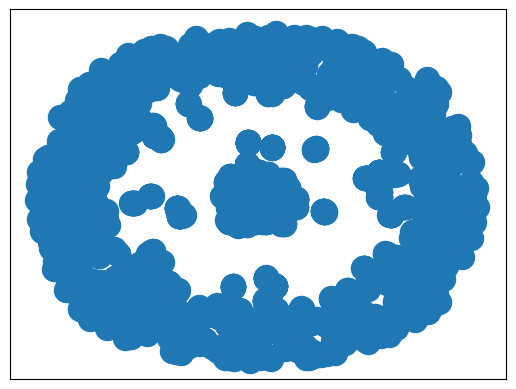

In [17]:
# Embeddings
networkx.draw_networkx(graph, with_labels=False)

# node2vec
node2vec = Node2Vec(graph, dimensions=20, walk_length=15, num_walks=200, workers=4)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Just an example to see if it works
for node, _ in model.wv.most_similar('Clint Eastwood'):
        print(node)


In [18]:
for node, _ in model.wv.most_similar('James Stewart'):
        print(node)

Lewuis Stone
Dean Miller
Adeline deWalt Reynolds
Anne Demetrio
Betty Garde
Kazi Orzazewski
William Powell
Helen Walker
Charley Grapwin
Emmett King


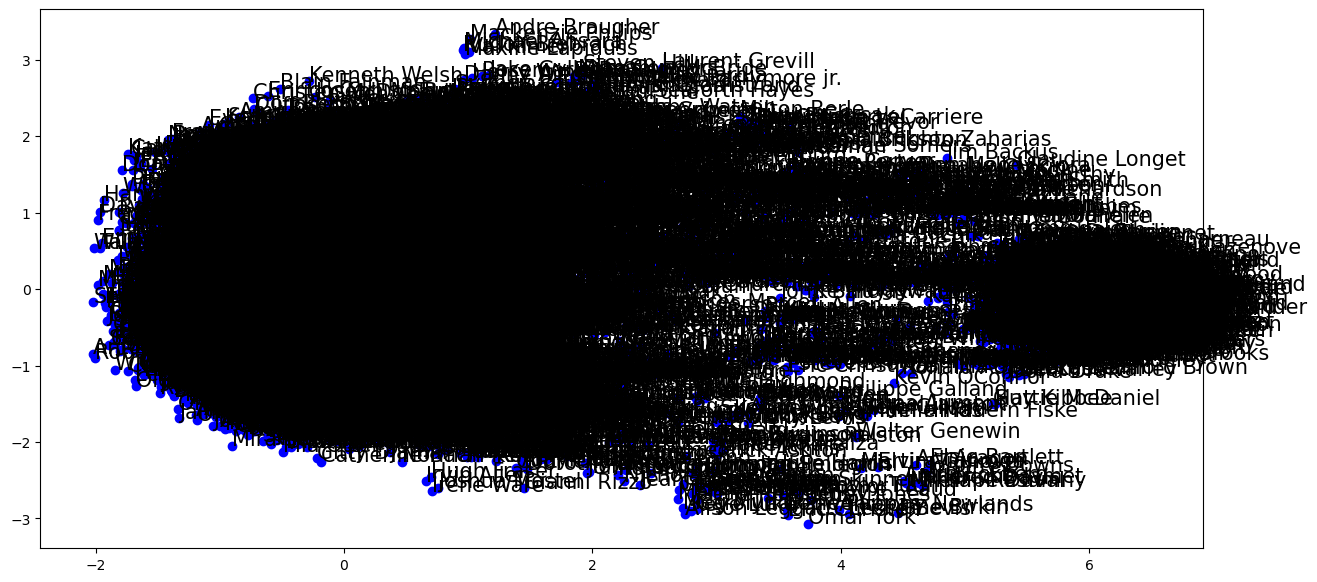

In [19]:
# visualize
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(model.wv.vectors)
plt.figure(figsize=(15, 7))
plt.scatter(pca_comps[:, 0], pca_comps[:, 1], c='blue')
for name, x, y in zip(graph.nodes(), pca_comps[:, 0], pca_comps[:, 1]):
        plt.annotate(name, xy=(x, y), size=15)
       
plt.savefig("graph_embeddings.png")

## Issues and possible extensions

I didn't have any particular issue in this homework, it just took a lot of time to get the results because the task is computationally expensive.
A possible extension could be this one: assuming we have a datebase containing all the films and actors in the world, an agency selecting actors for film companies could use this type of analysis to select actors who have worked on films of the same genre in the past and then select actors who have something in common with them (e.g. they have worked on the same film in the past).